In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

## EDA

In [63]:
df = pd.read_csv('../2021_matches.csv')
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,118.0,748.0,-56.0,-4.0,2.0,0.0,1.0,0.0,1.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,84.0,2120.0,3405.0,62.0,3.0,2.0,0.0,2.0,0.0,3.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,143.0,1578.0,354.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,120.0,124.0,102.0,10.0,0.0,4.0,2.0,1.0,1.0,2.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1,10.25,...,25.0,448.0,450.0,3.0,1.0,4.0,0.0,0.0,2.0,2.0


### Added death_adj field to prevent divide by zero issues for KDA calc

In [3]:
df['death_adj'] =  df.deaths.map(lambda x: 1 if x==0 else x)
df['kda'] = (df.kills + df.assists)/df.death_adj

## Converted 'side' field to a 1/0

In [4]:
df['side_bool'] = df.side.map(lambda x: 1 if x == 'Blue' else 0)

### Creating KDA by position fields

In [5]:
pos_lst = ['top','jng','mid','bot','sup']

df_teams = df[df.position == 'team'].reset_index()
df_teams['id_side'] = df_teams.gameid + '_' + df_teams.side
df_teams.set_index('id_side')

df_players = df[df.position != 'team']

Created pivoted table of kda by position grouped by the gameid+side; to be joined with the teams dataframe

In [6]:
df_players_piv = df_players[['position','kda']].pivot(values ='kda',columns = 'position')

df_players_piv['gameid'] = df_players.gameid
df_players_piv['side'] = df_players.side
df_players_piv['id_side'] = df_players_piv.gameid + '_' + df_players_piv.side

df_players_piv = df_players_piv.fillna(0)
df_players_piv.head(10)
df_players_piv = df_players_piv.groupby(['id_side']).sum().reset_index()
df_players_piv.set_index('id_side')

position,bot,jng,mid,sup,top
id_side,,,,,
0,58.400000,48.666667,41.250,43.300000,25.050000
6909-9183_Blue,1.000000,1.000000,2.000,0.250000,2.000000
6909-9183_Red,8.000000,7.000000,7.000,4.000000,7.000000
6909-9184_Blue,1.500000,1.833333,3.000,1.500000,0.714286
6909-9184_Red,20.000000,2.000000,8.500,2.500000,7.666667
...,...,...,...,...,...
NA1_3991749766_Red,0.500000,0.333333,0.125,0.250000,0.300000
NA1_3991779940_Blue,1.600000,0.636364,0.375,0.461538,0.181818
NA1_3991779940_Red,10.500000,28.000000,5.000,4.400000,21.000000


Joined the position pivot onto the teams dataframe on the gameid+side

In [7]:
df_agg = df_teams.set_index('id_side').join(df_players_piv.set_index('id_side'))

In [74]:
col_lst = ['kda','top','jng','mid','bot','sup','side_bool','result','csdiffat15','killsat15','assistsat15','deathsat15','golddiffat15']
df_plot = df_agg[col_lst].dropna()

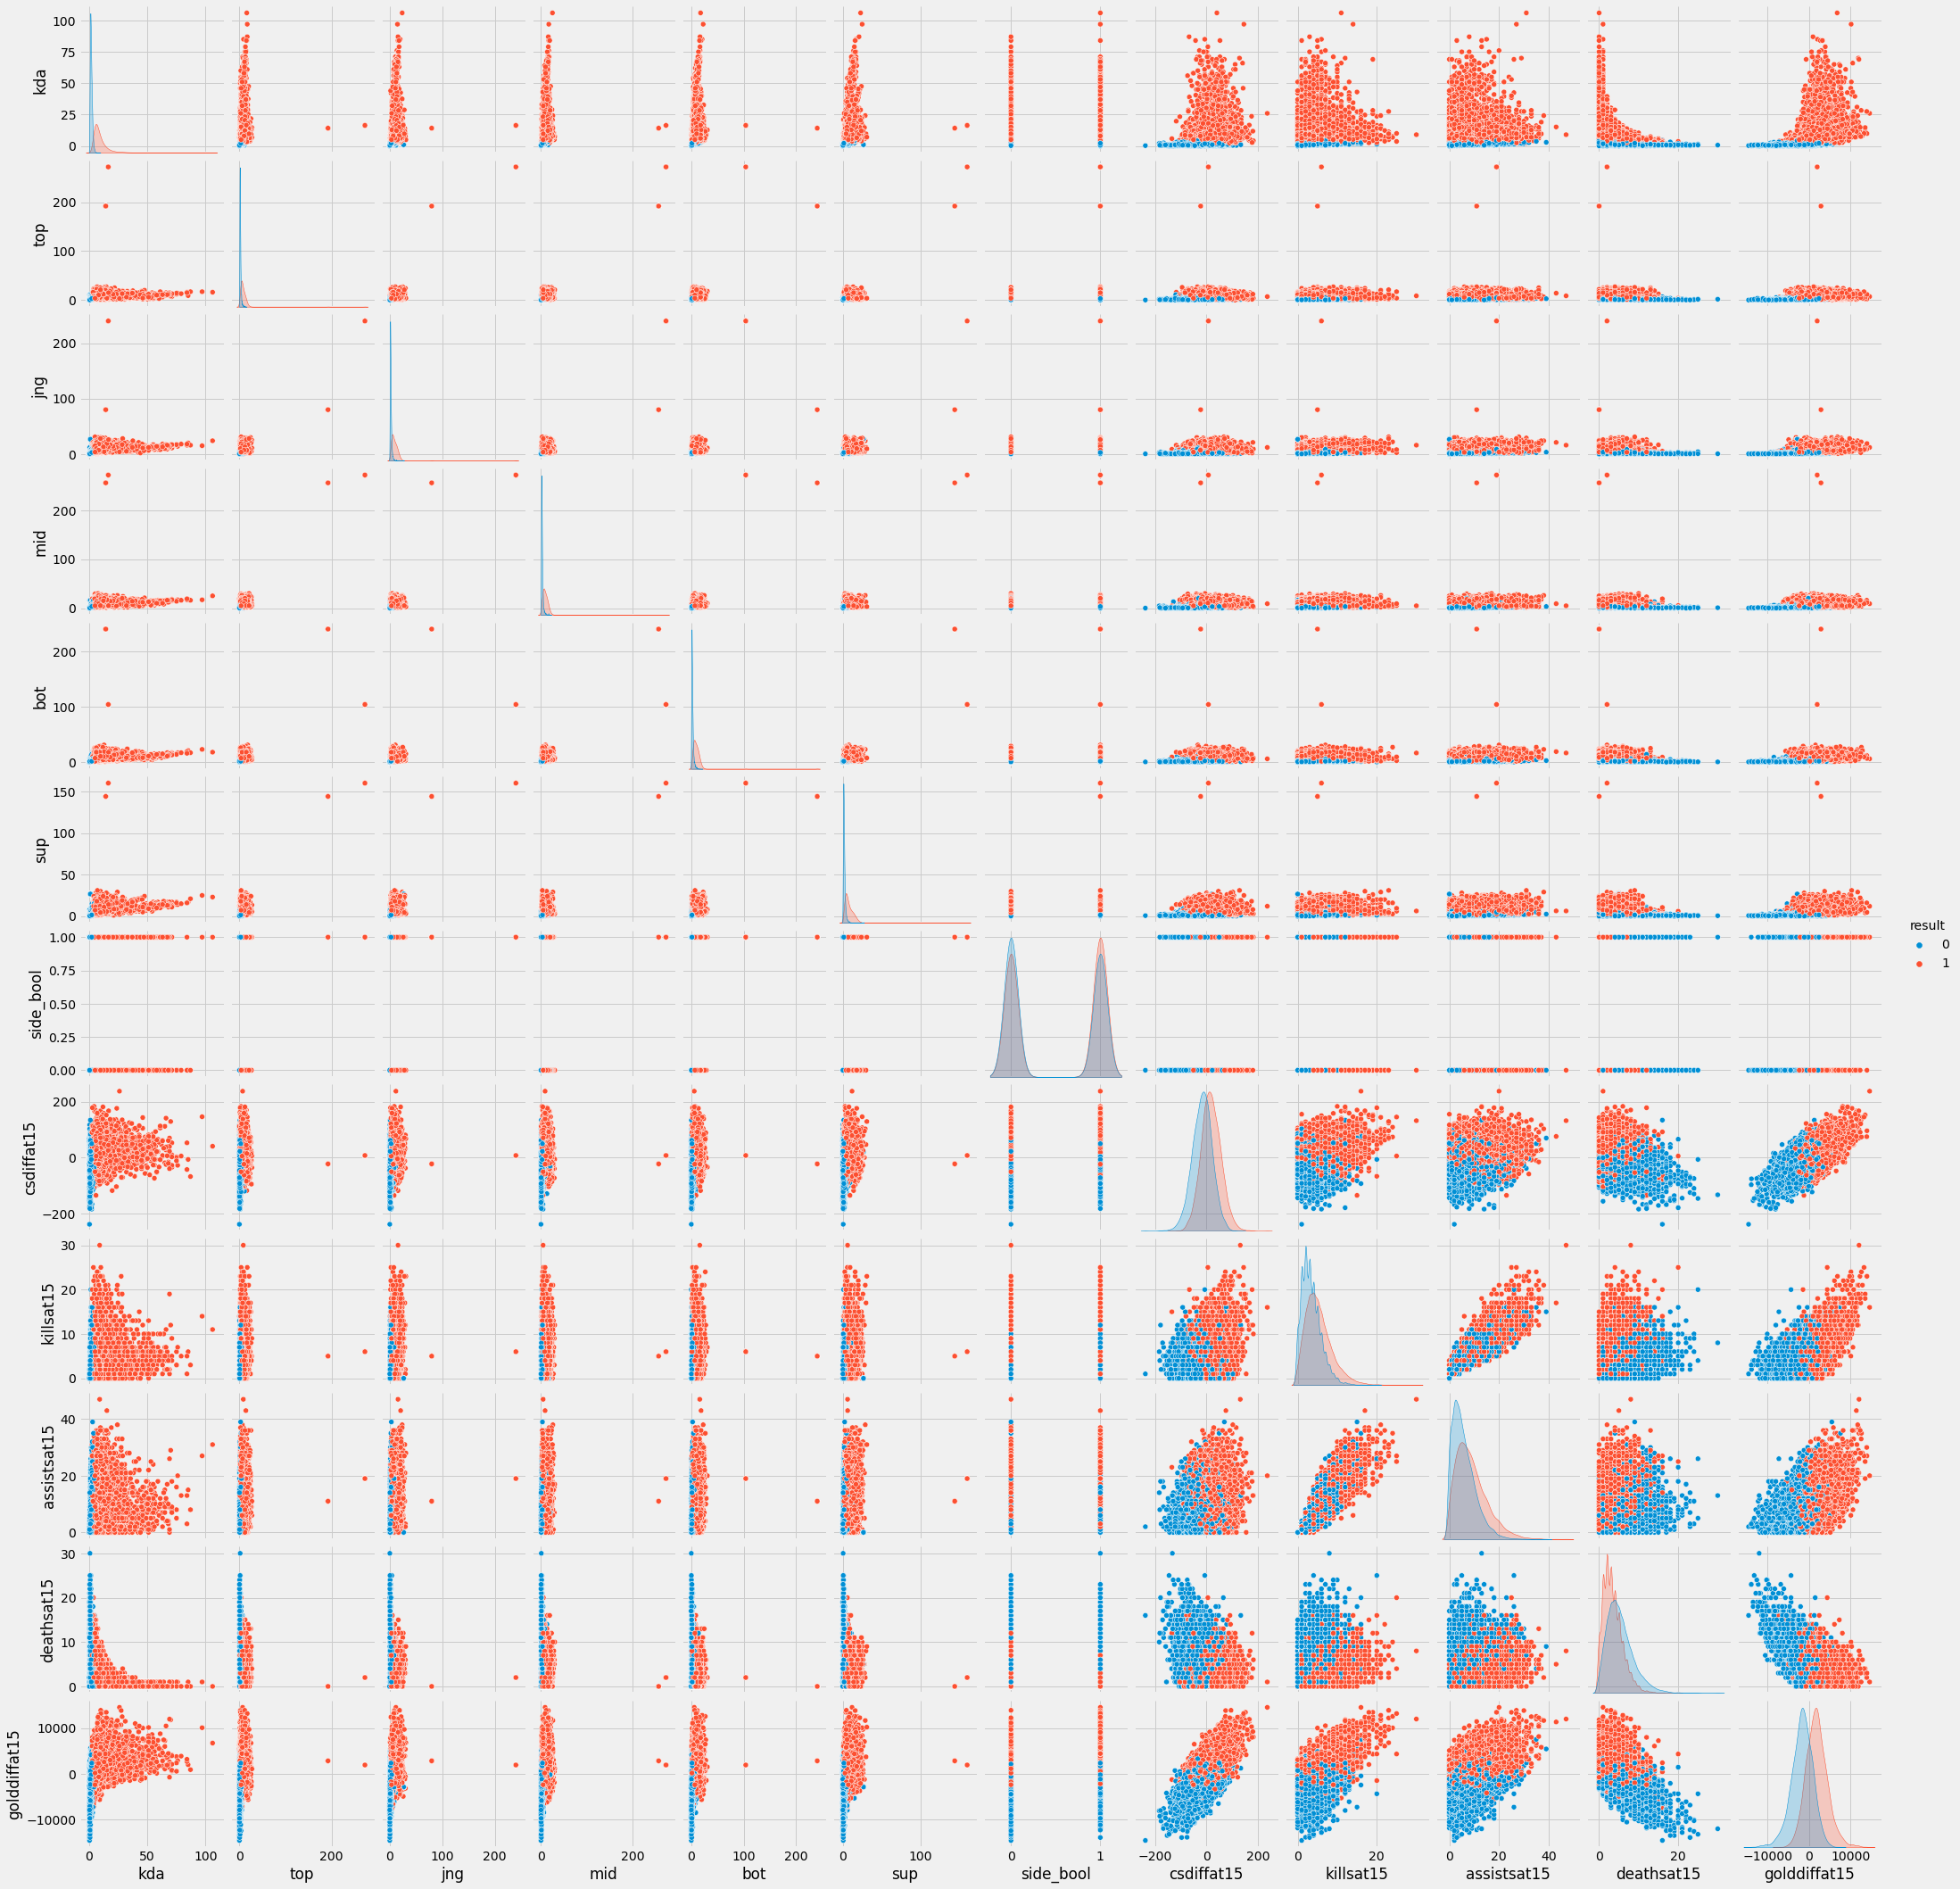

In [81]:
sns.pairplot(df_plot, hue = 'result')

In [75]:
X_train, X_test, y_train, y_test = train_test_split(df_plot.drop(columns = 'result'), df_plot['result'],
                                                    test_size = 0.2, random_state=42)

train_df = X_train.copy()
train_df['result'] = y_train

In [76]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/home/matt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [77]:
y_pred = lr.predict(X_test)

In [78]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.9198292220113852
0.8938793483047116
0.9543958627174424


[[1848  241]
 [  97 2030]]


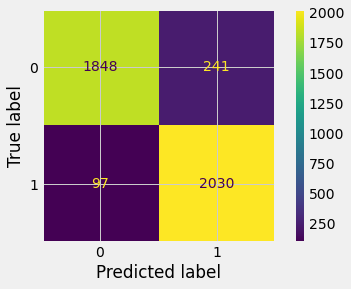

In [80]:
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(lr, X_test, y_test)

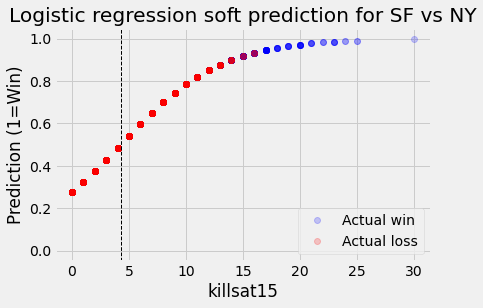

In [70]:
def viz_SF_LR(df, feat, model, hard_classification=True, decision_boundary=False):
    model.fit(df[[feat]], df['result'])
    
    # extract elevation feature and hard or soft predictions
    feature = df[[feat]].values
    if hard_classification:
        predictions = model.predict(feature)
    else:
        predictions = model.predict_proba(feature)[:, 1] 

    # color filter true class labels and plot predictions
    sf_mask = (df['result'] == 1).values
    plt.plot(feature[sf_mask], predictions[sf_mask], 'bo', label='Actual win', alpha=0.2)
    plt.plot(feature[~sf_mask], predictions[~sf_mask], 'ro', label='Actual loss', alpha=0.2)
    
    # optionally calculate and display decision boundary as dotted line
    if decision_boundary:
        b_0, b_1 = model.intercept_, model.coef_[0]
        plt.gca().axvline(-b_0/b_1,c='k',ls='--',lw=1)
    
    # plot formatting
    plt.ylim(-0.05, 1.05)
    plt.xlabel(feat)
    plt.ylabel('Prediction (1=Win)')
    type_str = 'hard' if hard_classification else 'soft'
    plt.title('Logistic regression ' + type_str + ' prediction for SF vs NY')
    plt.legend(loc='lower right')

lr1 = LogisticRegression()

viz_SF_LR(train_df, 'killsat15', lr1, hard_classification=False, decision_boundary = True)



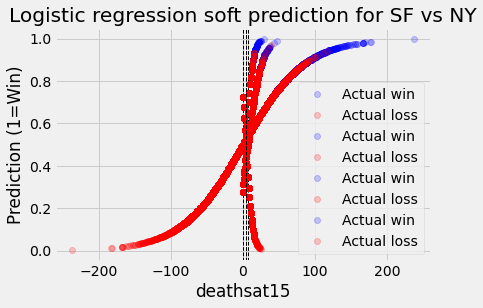

In [59]:
fift_lst = ['csdiffat15','assistsat15','killsat15','deathsat15']
for feat in fift_lst:
    viz_SF_LR(train_df, feat, lr1, hard_classification=False, decision_boundary = True)